In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/'

Mounted at /content/drive


[OPTIONAL] Extract .zip Dataset

In [2]:
import os
import zipfile

zip_file_path = '/content/drive/My Drive/Dataset8.zip'
extract_path_drive = '/content/drive/My Drive/'

os.makedirs(extract_path_drive, exist_ok=True)

print(f"Attempting to extract {zip_file_path} to {extract_path_drive}")

!unzip -o -q "{zip_file_path}" -d "{extract_path_drive}"

print("\nExtraction complete!")

Attempting to extract /content/drive/My Drive/Dataset8.zip to /content/drive/My Drive/

Extraction complete!


In [3]:
!pip install -q -U albumentations

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


[OPTIONAL] Dataset Size Verification

In [4]:
root_path = '/content/drive/MyDrive/Dataset8/' #CHANGE PATH

for subfolder in os.listdir(root_path):
    full_path = os.path.join(root_path, subfolder)
    if os.path.isdir(full_path):
        count = sum([len(files) for _, _, files in os.walk(full_path)])
        print(f"{subfolder}: {count} images")


test: 381 images
train: 892 images
valid: 358 images


Image Preprocessing (Albumentations)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-5-2860389994.py:21: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.2), # Occlusion


--- Image Counts in Each Dataset ---
Number of original images in the training folder: 892
Number of heavily augmented images added to training set: 892
Total number of samples in the FINAL training set (original + augmented): 1784
Number of images in the validation set: 358
Number of images in the test set: 381


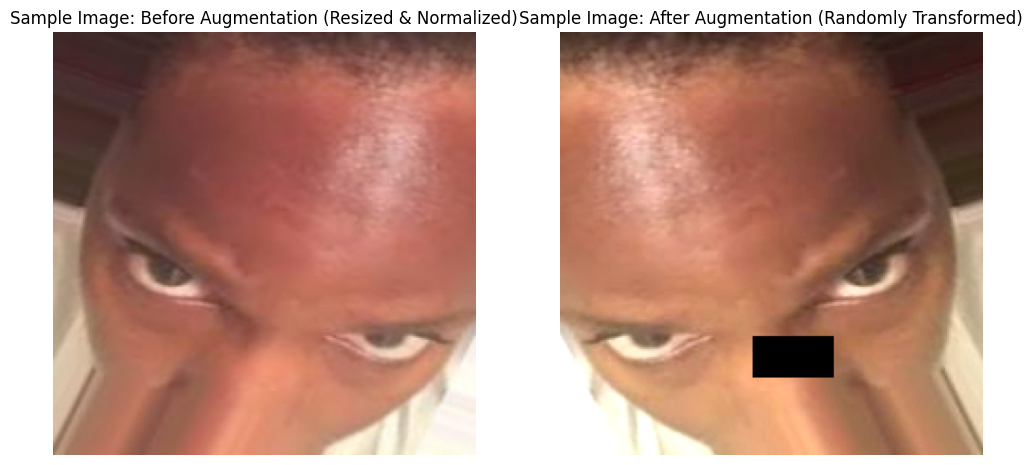

In [5]:
import os
import cv2
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

size = 224

# 1. Transformation for heavily augmented images (your original train_transform)
augmented_train_transform = A.Compose([
    A.Resize(size, size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1), # Keep if relevant to burn image orientation
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5), # More geometric
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5), # Color variations
    A.GaussNoise(p=0.2), # Adds noise
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.2), # Occlusion
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# 2. Transformation for "original" images (just resize and normalize)
# This is similar to your test_val_transform, ensuring consistency for the 'base' images.
base_train_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Transformation for validation and test sets remains the same
test_val_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Custom Dataset class (as provided in your code)
class AlbumentationsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.dataset = ImageFolder(folder_path)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = cv2.imread(path)
        if image is None:
            print(f"Warning: Could not load image at path: {path}. Skipping or handling.")
            raise FileNotFoundError(f"Image not found or corrupted at path: {path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for Albumentations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

# Base path for your dataset
base_path = '/content/drive/MyDrive/Dataset8'

# Verify base_path exists before proceeding
if not os.path.exists(base_path):
    print(f"Error: Dataset base path '{base_path}' does not exist. Please check your Google Drive mount and path.")

else:
    original_train_dataset = AlbumentationsDataset(os.path.join(base_path, 'train'), transform=base_train_transform)
    augmented_train_dataset = AlbumentationsDataset(os.path.join(base_path, 'train'), transform=augmented_train_transform)

    final_train_dataset = torch.utils.data.ConcatDataset([original_train_dataset, augmented_train_dataset])
    val_dataset   = AlbumentationsDataset(os.path.join(base_path, 'valid'), transform=test_val_transform)
    test_dataset  = AlbumentationsDataset(os.path.join(base_path, 'test'),  transform=test_val_transform)

    BATCH_SIZE = 32

    train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # --- Print Counts for each set ---
    print("--- Image Counts in Each Dataset ---")
    print(f"Number of original images in the training folder: {len(original_train_dataset)}")
    print(f"Number of heavily augmented images added to training set: {len(augmented_train_dataset)}")
    print(f"Total number of samples in the FINAL training set (original + augmented): {len(final_train_dataset)}")
    print(f"Number of images in the validation set: {len(val_dataset)}")
    print(f"Number of images in the test set: {len(test_dataset)}")

try:
    # Initialize a temporary dataset to get image paths
    temp_dataset = ImageFolder(os.path.join(base_path, 'train'))
    if len(temp_dataset) == 0:
        print(f"Error: No images found in '{os.path.join(base_path, 'train')}'. Cannot visualize.")
    else:
        # Get the path to the first image
        sample_image_path, _ = temp_dataset.samples[0]
        original_image_np = cv2.imread(sample_image_path)
        if original_image_np is None:
            raise FileNotFoundError(f"Could not load image from {sample_image_path}")
        original_image_np = cv2.cvtColor(original_image_np, cv2.COLOR_BGR2RGB) # Convert to RGB

        # --- Apply transforms and denormalize for visualization ---
        # Get 'before' image (just resized and normalized)
        before_augmentation_tensor = base_train_transform(image=original_image_np)['image']

        # Get 'after' image (with full augmentations)
        after_augmentation_tensor = augmented_train_transform(image=original_image_np)['image']

        # Denormalization function
        def denormalize(tensor_image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
            mean = torch.tensor(mean).view(3, 1, 1)
            std = torch.tensor(std).view(3, 1, 1)
            img = tensor_image * std + mean
            img = img.permute(1, 2, 0).cpu().numpy() # Convert C, H, W to H, W, C and to NumPy
            img = np.clip(img * 255, 0, 255).astype(np.uint8) # Scale to 0-255 and convert to uint8
            return img

        # Denormalize images for display
        before_display = denormalize(before_augmentation_tensor)
        after_display = denormalize(after_augmentation_tensor)

        # --- Plotting ---
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(before_display)
        plt.title('Sample Image: Before Augmentation (Resized & Normalized)')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(after_display)
        plt.title('Sample Image: After Augmentation (Randomly Transformed)')
        plt.axis('off')

        plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the dataset path and image files are correct and accessible.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please check your environment setup.")


Build Model

In [6]:
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
import os
from tqdm import tqdm

class BurnClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        self.features = mobilenet.features
        feature_channels = 960

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Global average pooling to flatten features
            nn.Flatten(),             # Flatten the output for linear layers

            # Layer 1
            nn.Linear(feature_channels, 512), # From 960 features to 512
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.4),               # Increased dropout for regularization

            # Layer 2 (Hidden Layer)
            nn.Linear(512, 256),           # From 512 to 256
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.3),               # Dropout

            # Layer 3
            nn.Linear(256, 128),           # From 256 to 128
            nn.SiLU(),
            nn.Dropout(0.2),

            # Output Layer
            nn.Linear(128, num_classes)    # Final layer mapping to the 3 burn classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

Early Stopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='best_model.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"⏳ EarlyStopping: {self.counter}/{self.patience} without improvement.")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"✅ Validation loss decreased ({self.val_loss_min:.4f} → {val_loss:.4f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

TRAINING LOOP


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BurnClassifier(num_classes=3).to(device)
EPOCHS = 30

# Optimization
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader), eta_min=1e-6)

# Loss Function
criterion = nn.CrossEntropyLoss()
#class_weights = torch.tensor([1.0, 1.5, 1.0]).to(device) # Example weights, tune these!
#criterion = nn.CrossEntropyLoss(weight=class_weights)

model_save_path = '/content/drive/MyDrive/final2.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

early_stopping = EarlyStopping(
    patience=7,
    verbose=True,
    delta=0.0005,
    path=model_save_path
)


# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0

    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix({
            'Batch Loss': f"{loss.item():.4f}",
            'Epoch Loss': f"{train_loss/(batch_idx+1):.4f}",
            'Accuracy': f"{100*correct/total:.2f}%"
        })

    # Validation after each epoch
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"📉 Validation Loss: {val_loss:.4f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Loading best model...")
        model.load_state_dict(torch.load(early_stopping.path))
        break # Exit the training loop

print(f"✅ Training finished. Best model weights saved to: {model_save_path}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 50.7MB/s]
Epoch [1/30]: 100%|██████████| 56/56 [00:18<00:00,  3.07it/s, Batch Loss=0.6934, Epoch Loss=0.9786, Accuracy=53.48%]


📉 Validation Loss: 0.8284
✅ Validation loss decreased (inf → 0.8284). Saving model ...


Epoch [2/30]: 100%|██████████| 56/56 [00:16<00:00,  3.46it/s, Batch Loss=0.4591, Epoch Loss=0.5184, Accuracy=81.45%]


📉 Validation Loss: 0.5550
✅ Validation loss decreased (0.8284 → 0.5550). Saving model ...


Epoch [3/30]: 100%|██████████| 56/56 [00:15<00:00,  3.66it/s, Batch Loss=0.2897, Epoch Loss=0.3013, Accuracy=88.45%]


📉 Validation Loss: 0.5753
⏳ EarlyStopping: 1/7 without improvement.


Epoch [4/30]: 100%|██████████| 56/56 [00:14<00:00,  3.76it/s, Batch Loss=0.2557, Epoch Loss=0.2184, Accuracy=91.09%]


📉 Validation Loss: 0.4719
✅ Validation loss decreased (0.5550 → 0.4719). Saving model ...


Epoch [5/30]: 100%|██████████| 56/56 [00:15<00:00,  3.69it/s, Batch Loss=0.1846, Epoch Loss=0.2129, Accuracy=92.10%]


📉 Validation Loss: 0.5419
⏳ EarlyStopping: 1/7 without improvement.


Epoch [6/30]: 100%|██████████| 56/56 [00:16<00:00,  3.40it/s, Batch Loss=0.0937, Epoch Loss=0.1901, Accuracy=92.60%]


📉 Validation Loss: 0.5356
⏳ EarlyStopping: 2/7 without improvement.


Epoch [7/30]: 100%|██████████| 56/56 [00:14<00:00,  3.76it/s, Batch Loss=0.1231, Epoch Loss=0.1699, Accuracy=93.89%]


📉 Validation Loss: 0.4098
✅ Validation loss decreased (0.4719 → 0.4098). Saving model ...


Epoch [8/30]: 100%|██████████| 56/56 [00:15<00:00,  3.72it/s, Batch Loss=0.0500, Epoch Loss=0.1311, Accuracy=94.45%]


📉 Validation Loss: 0.4983
⏳ EarlyStopping: 1/7 without improvement.


Epoch [9/30]: 100%|██████████| 56/56 [00:19<00:00,  2.82it/s, Batch Loss=0.1073, Epoch Loss=0.1279, Accuracy=94.90%]


📉 Validation Loss: 0.5438
⏳ EarlyStopping: 2/7 without improvement.


Epoch [10/30]: 100%|██████████| 56/56 [00:14<00:00,  3.86it/s, Batch Loss=0.1281, Epoch Loss=0.1262, Accuracy=94.96%]


📉 Validation Loss: 0.5290
⏳ EarlyStopping: 3/7 without improvement.


Epoch [11/30]: 100%|██████████| 56/56 [00:14<00:00,  3.75it/s, Batch Loss=0.4302, Epoch Loss=0.1396, Accuracy=94.34%]


📉 Validation Loss: 0.4864
⏳ EarlyStopping: 4/7 without improvement.


Epoch [12/30]: 100%|██████████| 56/56 [00:14<00:00,  3.78it/s, Batch Loss=0.1207, Epoch Loss=0.1166, Accuracy=96.13%]


📉 Validation Loss: 0.4818
⏳ EarlyStopping: 5/7 without improvement.


Epoch [13/30]: 100%|██████████| 56/56 [00:14<00:00,  3.76it/s, Batch Loss=0.0835, Epoch Loss=0.1145, Accuracy=95.46%]


📉 Validation Loss: 0.5337
⏳ EarlyStopping: 6/7 without improvement.


Epoch [14/30]: 100%|██████████| 56/56 [00:14<00:00,  3.78it/s, Batch Loss=0.1059, Epoch Loss=0.0880, Accuracy=96.75%]


📉 Validation Loss: 0.6087
⏳ EarlyStopping: 7/7 without improvement.
Early stopping triggered. Loading best model...
✅ Training finished. Best model weights saved to: /content/drive/MyDrive/final2.pth


Evaluation Report

In [9]:
from sklearn.metrics import classification_report, confusion_matrix


model.eval()

# Evaluation on Test Set
y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

class_names = test_dataset.dataset.classes

print("\nClassification Report on Test Set:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix for BurnClassifier Model (Augmented + Multilayered Head):")
print(confusion_matrix(y_true, y_pred))


Classification Report on Test Set:
              precision    recall  f1-score   support

  1st degree       0.86      0.91      0.88       133
  2nd degree       0.86      0.82      0.84       131
  3rd degree       0.95      0.94      0.94       117

    accuracy                           0.89       381
   macro avg       0.89      0.89      0.89       381
weighted avg       0.89      0.89      0.89       381


Confusion Matrix for BurnClassifier Model (Augmented + Multilayered Head):
[[121  12   0]
 [ 18 107   6]
 [  2   5 110]]


[IMP] Export Model

In [10]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile
import os
import collections

class BurnClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        mobilenet = models.mobilenet_v3_large(pretrained=True)
        self.features = mobilenet.features
        feature_channels = 960

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),

            # Layer 1
            nn.Linear(feature_channels, 512), # From 960 features to 512
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.4),               # Increased dropout for regularization

            # Layer 2 (Hidden Layer)
            nn.Linear(512, 256),           # From 512 to 256
            nn.SiLU(),                     # Swish (SiLU) activation
            nn.Dropout(0.3),               # Dropout

            # Layer 3
            nn.Linear(256, 128),           # From 256 to 128
            nn.SiLU(),
            nn.Dropout(0.2),

            # Output Layer
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- Configuration for Model Optimization ---
original_state_dict_path = '/content/drive/MyDrive/final2.pth' #CHANGE FILE NAME
output_model_name = 'burnaidmodel.pt'
output_dir = '/content/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
output_model_full_path = os.path.join(output_dir, output_model_name)

print(f"Starting model optimization for CPU inference...")

#  Model Instantiation and Loading
try:
    model = BurnClassifier(num_classes=3)
    state_dict = torch.load(original_state_dict_path, map_location=torch.device('cpu'))

    model.load_state_dict(state_dict)
    model.eval() # Set to evaluation mode
    print("Original model loaded successfully onto CPU from state_dict.")
except Exception as e:
    print(f"Error instantiating or loading state_dict into model from {original_state_dict_path}: {e}")
    print("Please ensure your 'BurnClassifier' class definition in this script is IDENTICAL to the one used for saving the model.")
    exit()

# Trace the model to TorchScript
dummy_input = torch.rand(1, 3, 224, 224).to(torch.device('cpu'))
print(f"Created dummy input of shape: {dummy_input.shape} on device: {dummy_input.device}")

traced_model = None
try:
    # Use torch.jit.trace for models that do not use data-dependent control flow
    traced_model = torch.jit.trace(model, dummy_input)
    print("Model traced successfully to TorchScript.")
except Exception as e:
    print(f"Error tracing model: {e}")
    print("If your model uses data-dependent control flow (e.g., if/else based on input values), tracing might fail.")
    print("Attempting torch.jit.script instead (for models with control flow)...")
    try:
        # Use torch.jit.script for models with control flow.
        traced_model = torch.jit.script(model)
        print("Model scripted successfully to TorchScript.")
    except Exception as e:
        print(f"Could not trace or script the model: {e}")
        print("Please review your model's architecture and PyTorch documentation for TorchScript conversion.")
        exit()

# Optimize the TorchScript model for mobile (CPU backend)
try:
    optimized_model = optimize_for_mobile(traced_model)
    print("Model optimized for mobile (CPU backend).")
except Exception as e:
    print(f"Error optimizing model for mobile: {e}")
    print("Ensure your PyTorch version is up-to-date and torch.utils.mobile_optimizer is available.")
    exit()

# Save the model in the Lite Interpreter format (.ptl)
try:
    optimized_model._save_for_lite_interpreter(output_model_full_path)
    print(f"Optimized model successfully saved to: {output_model_full_path}")
except Exception as e:
    print(f"Error saving optimized model to {output_model_full_path}: {e}")
    print("Please check write permissions for the output directory or available disk space.")
    exit()

print("\nModel optimization complete.")
print("The 'burnaidmodel.pt' file is ready for integration into your mobile application.")
print("Remember to place it in your Flutter project's 'assets/models/' folder or equivalent.")


Starting model optimization for CPU inference...
Original model loaded successfully onto CPU from state_dict.
Created dummy input of shape: torch.Size([1, 3, 224, 224]) on device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model traced successfully to TorchScript.
Model optimized for mobile (CPU backend).
Optimized model successfully saved to: /content/burnaidmodel.pt

Model optimization complete.
The 'burnaidmodel.pt' file is ready for integration into your mobile application.
Remember to place it in your Flutter project's 'assets/models/' folder or equivalent.


Random Image Test (UPLOAD BURN IMAGES IN /content)

In [20]:
import torch
import cv2
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2

# Load TorchScript model
model = torch.jit.load("/content/burnaidmodel.pt")
model.eval()

# Define transforms matching your test_val_transform
transform = Compose([
    Resize(224, 224),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Load image
img = cv2.imread("/content/13.jpg")  # Replace with actual image name
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply transform
transformed = transform(image=img)["image"]
input_tensor = transformed.unsqueeze(0)  # Add batch dimension [1, 3, 224, 224]

# Run inference
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1)
    print("Predicted class:", pred.item())
    print("Raw logits:", output.tolist())


Predicted class: 1
Raw logits: [[-0.5131025314331055, 1.1216143369674683, -0.47025084495544434]]
